In [4]:
import osmnx as ox
import networkx as nx
import rustworkx as rx
import numpy as np
import h3
from timeit import default_timer as timer

timetable = {}

def node_to_hex(node, resolution):
    lat = node['y']
    lon = node['x']
    return h3.latlng_to_cell(lat, lon, resolution)

def nodes_to_hexes(G, resolution):
    """Maps H3 hexagons to their contained nodes."""
    nodes = G.nodes(data=True)
    h3_to_nodes = {}
    
    for node_id, data in nodes:
        h3_hex = node_to_hex(data, resolution)
        if h3_hex not in h3_to_nodes:
            h3_to_nodes[h3_hex] = []
        h3_to_nodes[h3_hex].append(node_id)
    
    return h3_to_nodes

def create_hex_pivot(node_mapping: np.ndarray) -> np.ndarray:
    """
    Creates a structured array of unique hexes with their contained node IDs.
    
    Returns a numpy array with dtype:
        - hex_id: The H3 hex identifier
        - nx_ids: Array of NetworkX node IDs in this hex
        - rx_idxs: Array of RustWorkX indices in this hex
    """
    # Get unique hex IDs and their counts
    unique_hexes, hex_counts = np.unique(node_mapping['hex_id'], return_counts=True)
    
    # Create dtype for the pivoted array
    pivot_dtype = np.dtype([
        ('hex_id', object),
        ('nx_ids', object),  # Will store arrays of varying length
        ('rx_idxs', object)  # Will store arrays of varying length
    ])
    
    # Initialize the pivoted array
    hex_pivot = np.empty(len(unique_hexes), dtype=pivot_dtype)
    
    # Fill the pivoted array
    for i, hex_id in enumerate(unique_hexes):
        # Get all nodes in this hex
        hex_mask = node_mapping['hex_id'] == hex_id
        nodes_in_hex = node_mapping[hex_mask]
        
        hex_pivot[i] = (
            hex_id,
            nodes_in_hex['nx_id'],  # nx_ids
            nodes_in_hex['rx_idx']    # rx_idxs
        )
    
    return hex_pivot

def retrieve_node_mapping_by_rx_idx(node_mapping, rx_idx):
    return node_mapping[np.where(node_mapping['rx_idx'] == rx_idx)][0]

def retrieve_node_mapping_by_nx_id(node_mapping, nx_id):
    return node_mapping[np.where(node_mapping['nx_id'] == nx_id)][0]

def rx_to_nx_node(rx_idx):
    return node_mapping[np.where(node_mapping['rx_idx'] == rx_idx)][0][0]

def nx_node_to_rx(nx_id):
    return node_mapping[np.where(node_mapping['nx_id'] == nx_id)][0][4]

# Step 1: Download Street Network
start = timer()
place_name = "Brenham, Texas, USA"
G = ox.graph_from_place(place_name, network_type='drive')
end = timer()
download_time = end - start
timetable['download_time'] = download_time
print(f"Street Network Download: {download_time:.2f} seconds")

# Step 2: Create node mapping with H3 indices
start = timer()

# Define the dtype for our structured array
node_dtype = np.dtype([
    ('nx_id', object),    # NetworkX node ID
    ('lon', np.float64),    # longitude
    ('lat', np.float64),    # latitude
    ('hex_id', object),     # H3 hex ID
    ('rx_idx', np.int64)    # Rustworkx index
])

# Pre-allocate the array based on number of nodes
G_rx = rx.PyGraph()
num_nodes = len(G)
node_mapping = np.empty(num_nodes, dtype=node_dtype)

# Fill the array with node information
for i, (node, data) in enumerate(G.nodes(data=True)):
    lat = data.get('y', 0.0)
    lon = data.get('x', 0.0)
    hex_id = h3.latlng_to_cell(lat, lon, 9)
    rx_idx = G_rx.add_node(i)  # Store the node data if needed
    
    node_mapping[i] = (
        node,       # node_id
        lon,        # longitude
        lat,        # latitude
        hex_id,     # H3 hex ID
        rx_idx      # Rustworkx index
    )

# Create edge connections
for u, v, data in G.edges(data=True):
    # Use searchsorted for efficient index lookup
    u_mask = node_mapping['nx_id'] == u
    v_mask = node_mapping['nx_id'] == v
    u_idx = node_mapping['rx_idx'][u_mask][0]
    v_idx = node_mapping['rx_idx'][v_mask][0]
    weight = data.get('length', 1.0)
    G_rx.add_edge(u_idx, v_idx, weight)

end = timer()
mapping_time = end - start
timetable['mapping_time'] = mapping_time
print(f"Node Mapping Creation: {mapping_time:.2f} seconds")
print(f"NetworkX Graph Contains {len(G.nodes())} nodes and {len(G.edges())} edges")
print(f"RustworkX Graph Contains {len(G_rx.nodes())} nodes and {len(G_rx.edges())} edges")

# Step 3: Create Distance Matrix between Nodes
start = timer()
# pre-computed matrix containing all shortest path distances between nodes
dist_matrix = rx.floyd_warshall_numpy(G_rx, weight_fn=lambda x: float(x))
np.fill_diagonal(dist_matrix, np.inf)
distance_calc = timer() - start
timetable['distance_calc'] = distance_calc
print(f"Node Distance Matrix Creation: {distance_calc:.2f} seconds")

# Step 4: Create Distance Matrix between Hexagons
start = timer()
h3_to_anchor_node = {hex_id: nodes[0] for hex_id, nodes in nodes_to_hexes(G, 8).items()}

hex_pairs = {}
for hex1, anchor1 in h3_to_anchor_node.items():
    for hex2, anchor2 in h3_to_anchor_node.items():
        idx1 = nx_node_to_rx(anchor1)
        idx2 = nx_node_to_rx(anchor2)
        dist = dist_matrix[idx1, idx2]
        if not np.isinf(dist):
            hex_pairs[(hex1, hex2)] = dist
hex_pairs_calc = timer() - start
timetable['hex_pairs_calc'] = hex_pairs_calc
print(f"Hex Pairs Calculation: {hex_pairs_calc:.2f} seconds")
print(f"Graph Contains {len(np.unique(node_mapping['hex_id']))} unique hexagons")

def get_or_create_anchor_node(hex_id):
    if hex_id not in h3_to_anchor_node:
        # Fallback: Pick any node in the hex if it wasn't precomputed
        nodes_in_hex = node_mapping[node_mapping['hex_id'] == hex_id]
        if len(nodes_in_hex) == 0:
            raise ValueError(f"No nodes found in hex {hex_id}")
        h3_to_anchor_node[hex_id] = nodes_in_hex['nx_id'][0]
    return h3_to_anchor_node[hex_id]

def find_shortest_path(origin_node, destination_node):
    origin_hex = node_to_hex(G.nodes[origin_node], 8)
    destination_hex = node_to_hex(G.nodes[destination_node], 8)

    # Try origin fallback if anchor is missing
    if origin_hex not in h3_to_anchor_node:
        origin_hex = find_nearest_valid_hex(origin_hex, h3_to_anchor_node)
        if origin_hex is None:
            print(f"Skipping: No valid anchor for origin {origin_node} in hex {origin_hex}")
            return None

    # Try destination fallback if anchor is missing
    if destination_hex not in h3_to_anchor_node:
        destination_hex = find_nearest_valid_hex(destination_hex, h3_to_anchor_node)
        if destination_hex is None:
            print(f"Skipping: No valid anchor for destination {destination_node} in hex {destination_hex}")
            return None

    anchor_origin = h3_to_anchor_node[origin_hex]
    anchor_dest = h3_to_anchor_node[destination_hex]

    origin_rx = nx_node_to_rx(origin_node)
    anchor_origin_rx = nx_node_to_rx(anchor_origin)
    anchor_dest_rx = nx_node_to_rx(anchor_dest)
    destination_rx = nx_node_to_rx(destination_node)

    same_anchor_hex = origin_hex == destination_hex
    same_origin_anchor = origin_node == anchor_origin
    same_dest_anchor = destination_node == anchor_dest

    # 1. Origin -> Anchor Origin
    if same_origin_anchor:
        path_nx_1 = [origin_node]
    else:
        path_rx_1 = rx.dijkstra_shortest_paths(G_rx, origin_rx, weight_fn=lambda x: float(x), target=anchor_origin_rx)
        if anchor_origin_rx not in path_rx_1:
            print(f"Skipping trip: No path from origin {origin_node} to anchor_origin {anchor_origin}")
            return None
        path_nx_1 = [rx_to_nx_node(i) for i in path_rx_1[anchor_origin_rx]]

    # 2. Anchor Origin -> Anchor Dest (Precomputed or Same)
    if same_anchor_hex:
        path_nx_2 = []  # They're the same; this segment is empty
    else:
        if (origin_hex, destination_hex) in hex_pairs:
            path_nx_2 = [anchor_origin, anchor_dest]  # Placeholder (precomputed distance used)
        else:
            path_rx_2 = rx.dijkstra_shortest_paths(G_rx, anchor_origin_rx, lambda x: float(x), target=anchor_dest_rx)
            if anchor_dest_rx not in path_rx_2:
                print(f"Skipping trip: No path between anchor_origin {anchor_origin} and anchor_dest {anchor_dest}")
                return None
            path_nx_2 = [rx_to_nx_node(i) for i in path_rx_2[anchor_dest_rx]]

    # 3. Anchor Dest -> Destination
    if same_dest_anchor:
        path_nx_3 = [destination_node]
    else:
        path_rx_3 = rx.dijkstra_shortest_paths(G_rx, anchor_dest_rx, weight_fn=lambda x: float(x), target=destination_rx)
        if destination_rx not in path_rx_3:
            print(f"Skipping trip: No path from anchor_dest {anchor_dest} to destination {destination_node}")
            return None
        path_nx_3 = [rx_to_nx_node(i) for i in path_rx_3[destination_rx]]

    # Combine the paths
    full_path_nx = path_nx_1 + path_nx_2[1:] + path_nx_3[1:]
    return full_path_nx

source_test_nodes = np.random.choice(G.nodes(), 100)
target_test_nodes = np.random.choice(G.nodes(), 100)
test_trips = list(zip(source_test_nodes, target_test_nodes))

execution_times = []
for i, trip in enumerate(test_trips):
    start = timer()
    find_shortest_path(trip[0], trip[1])
    end = timer()
    execution_times.append(end - start)

print(f"Average Execution Time: {np.mean(execution_times):.6f} seconds per trip")

Street Network Download: 0.44 seconds
Node Mapping Creation: 0.05 seconds
NetworkX Graph Contains 1154 nodes and 3020 edges
RustworkX Graph Contains 1154 nodes and 3020 edges
Node Distance Matrix Creation: 0.22 seconds
Hex Pairs Calculation: 0.04 seconds
Graph Contains 210 unique hexagons
Average Execution Time: 0.000128 seconds per trip


In [5]:
def calculate_path_distance_rx(G_rx, path_rx):
    if len(path_rx) < 2:
        return 0.0

    total_distance = 0.0
    for i in range(len(path_rx) - 1):
        u, v = path_rx[i], path_rx[i + 1]
        edge_weight = None
        for edge in G_rx.edges(u):
            if edge[1] == v:
                edge_weight = float(edge[2])
                break
        if edge_weight is None:
            raise ValueError(f"No edge between {u} and {v} in RustworkX")
        total_distance += edge_weight

    return total_distance

def find_and_measure_path(G_rx, origin_rx, destination_rx):
    path_rx = rx.dijkstra_shortest_paths(G_rx, origin_rx, target=destination_rx, weight_fn=lambda x: float(x))

    if destination_rx not in path_rx:
        return None, 0.0

    path_nodes = path_rx[destination_rx]

    distance = calculate_path_distance_rx(G_rx, path_nodes)
    return path_nodes, distance

In [6]:
find_shortest_path(np.random.choice(source_test_nodes), np.random.choice(target_test_nodes))

[229502122,
 229485842,
 229488180,
 229488203,
 229516897,
 11603136723,
 229417912,
 229417909,
 229417905,
 229417900,
 229351847,
 229440345,
 229440340,
 229416380,
 229416379,
 229416374,
 229416366,
 229416363,
 229416357,
 229416354,
 229416352]

In [7]:
def calculate_path_distance(G, path_nx):
    if len(path_nx) < 2:
        return 0.0

    total_distance = 0.0
    for i in range(len(path_nx) - 1):
        u, v = path_nx[i], path_nx[i + 1]
        
        if G.has_edge(u, v):
            # Multi-edge safe approach
            edge_data = G.get_edge_data(u, v)
            if isinstance(edge_data, dict):
                first_edge_key = next(iter(edge_data))
                total_distance += edge_data[first_edge_key]['length']
            else:
                total_distance += edge_data['length']
        
        elif G.has_edge(v, u):
            edge_data = G.get_edge_data(v, u)
            if isinstance(edge_data, dict):
                first_edge_key = next(iter(edge_data))
                total_distance += edge_data[first_edge_key]['length']
            else:
                total_distance += edge_data['length']
        
        else:
            raise ValueError(f"No edge between {u} and {v}")

    return total_distance


In [8]:
test_path = find_shortest_path(np.random.choice(source_test_nodes), np.random.choice(target_test_nodes))

In [9]:
calculate_path_distance(G, test_path)

ValueError: No edge between 229351847 and 229136565

In [ ]:
def get_shortest_path_length(h3_source, h3_target):
    if h3_source == h3_target:
        return 0

    if (h3_source, h3_target) in hex_pairs:
        return hex_pairs[(h3_source, h3_target)]

    source_node = h3_to_anchor_node.get(h3_source)
    target_node = h3_to_anchor_node.get(h3_target)

    if source_node is None or target_node is None:
        raise ValueError("One or both hexes have no representative node")

    source_idx = nx_node_to_rx(source_node)
    target_idx = nx_node_to_rx(target_node)

    path_data = rx.dijkstra_shortest_paths(
        G_rx, source_idx, lambda edge: float(edge)
    )

    distances = path_data["distances"]
    length = distances.get(target_idx, float('inf'))

    return length

In [ ]:
# Source: 88446dbb45fffff
# Target: 88446d8eddfffff

In [20]:
get_shortest_path_length('88446dbb45fffff', '88446d8eddfffff')

4625.518999999999

In [29]:
# Function to compute shortest paths between hexagons
def compute_hex_paths(G_rx, hex_to_nodes, source_hex, target_hex):
    """
    Compute shortest paths between all nodes in source_hex to all nodes in target_hex
    """
    paths = {}
    source_nodes = hex_to_nodes[source_hex]
    target_nodes = hex_to_nodes[target_hex]
    
    for source in source_nodes:
        paths[source] = {}
        # Using NetworkX's single_source_dijkstra for efficiency
        lengths, paths_dict = nx.single_source_dijkstra(G, source, weight='length')
        for target in target_nodes:
            if target in lengths:
                paths[source][target] = {
                    'distance': lengths[target],
                    'path': paths_dict[target]
                }
    
    return paths

# Example usage for pre-computing paths between hexagons
def precompute_hex_paths(G, hex_to_nodes):
    """
    Pre-compute shortest paths between all hexagon pairs
    """
    hex_paths = {}
    hexagons = list(hex_to_nodes.keys())
    
    start = timer()
    total_pairs = len(hexagons) * (len(hexagons) - 1) // 2
    computed = 0
    
    for i, hex1 in enumerate(hexagons):
        hex_paths[hex1] = {}
        for hex2 in hexagons[i+1:]:
            hex_paths[hex1][hex2] = compute_hex_paths(G, hex_to_nodes, hex1, hex2)
            computed += 1
            if computed % 10 == 0:  # Progress update every 10 pairs
                print(f"Computed {computed}/{total_pairs} hexagon pairs")
    
    end = timer()
    timetable['path_computation_time'] = end - start
    print(f"Path Computation Time: {end-start:.2f} seconds")
    
    return hex_paths

In [40]:
node_mapping

array([(229134561, -96.3912929, 30.144031 , '88446d8eddfffff',    0),
       (229134590, -96.389991 , 30.144892 , '88446d8eddfffff',    1),
       (229135488, -96.3705723, 30.1715121, '88446d8eb9fffff',    2), ...,
       (11201114401, -96.401673 , 30.1820824, '88446dbb45fffff', 1151),
       (11603136723, -96.3869864, 30.1622537, '88446d8e9dfffff', 1152),
       (11603136727, -96.3874119, 30.1634256, '88446d8e9dfffff', 1153)],
      dtype=[('nx_id', 'O'), ('lon', '<f8'), ('lat', '<f8'), ('hex_id', 'O'), ('rx_idx', '<i8')])

In [41]:
create_hex_pivot(node_mapping)

array([('88446d8535fffff', array([229342684, 229342739, 229409370, 229409378, 229435069, 229504061],
             dtype=object), array([ 82,  83,  91,  92, 347, 779]))                                  ,
       ('88446d8537fffff', array([229416726, 229434330, 229460186, 229460203, 229477721, 229497781,
              6887422915, 6887422916], dtype=object), array([ 125,  346,  521,  522,  641,  740, 1062, 1063])),
       ('88446d85a1fffff', array([229418410, 229421815, 229421820, 229421824, 229424129, 229425047,
              229425052, 229425054, 229425055, 229427563, 229427576, 229427581,
              229433231, 229433235, 229449209, 229454914, 229460327, 229476451,
              229476455, 229487082, 229508145, 229508149, 229508153, 229508168,
              229513611, 1152969720, 1153132503, 1153132507, 3025722594,
              3025771765, 6012957878, 6012957879, 6012957880, 9976292889,
              9976292894, 10649482337, 10649482373], dtype=object), array([ 156,  179,  180,  181,

In [10]:
# Step 5: Save to Disk
start = timer()
with open('precomputed_paths_nx.pkl', 'wb') as f:
    pickle.dump(precomputed_paths_nx, f)
#with open('precomputed_paths_rx.pkl', 'wb') as f:
#    pickle.dump(precomputed_paths_rx, f)
end = timer()
save_time = end - start
timetable['save_time'] = save_time
print(f"Saving Precomputed Paths: {save_time:.2f} seconds")

Saving Precomputed Paths: 0.00 seconds


In [11]:
# Summary Table
print("\nExecution Time Summary (%d nodes):" % len(G.nodes))
print(f"{'Step':<45}{'Time (s)'}")
print(f"{'-'*55}")
print(f"{'Download Street Network':<45}{timetable['download_time']  :.2f}")
print(f"{'Node-to-H3 Mapping':<45}{timetable['mapping_time']:.2f}")
print(f"{'Shortest Path Precomputation w/ NetworkX':<45}{timetable['precomputation_time_nx']:.2f}")
#print(f"{'Shortest Path Precomputation w/ Rustworkx':<45}{timetable['precomputation_time_rx']:.2f}")
print(f"{'Saving Precomputed Paths':<45}{timetable['save_time']:.2f}")

NameError: name 'G' is not defined

In [84]:
precomputed_paths_rx

{}

In [67]:
precomputed_paths_nx

{('892ab3ad533ffff', '892ab3ae317ffff'): (35,
  [229937272,
   230306670,
   230365662,
   230510482,
   230210551,
   230210564,
   230046113,
   230046084,
   229954902,
   1765710678,
   307612490,
   230001987,
   7243795200,
   7243795244,
   230345843,
   538765023,
   538765231,
   538764687,
   230345667,
   229945765,
   229945786,
   229940182,
   230053211,
   230053185,
   230053150,
   230053131,
   230039544,
   230102287,
   230079020,
   230102312,
   230102325,
   230516513,
   230119679,
   230119718,
   230119741,
   229937390]),
 ('892ab3ae317ffff', '892ab3ad533ffff'): (35,
  [229937390,
   230119741,
   230119718,
   230119679,
   230516513,
   230102325,
   230102312,
   230079020,
   230102287,
   230039544,
   230053131,
   230053150,
   230053185,
   230053211,
   229940182,
   229945786,
   229945765,
   230345667,
   538764687,
   538765231,
   538765023,
   230345843,
   7243795244,
   7243795200,
   230001987,
   307612490,
   1765710678,
   229954902,
   2

In [85]:
source_idx = nx_to_rx_map[nodes[0]]
target_idx = nx_to_rx_map[nodes[1]]
path = rx.dijkstra_shortest_paths(G_rx, source_idx, target_idx)
print(path)

PathMapping{2: [0, 4030, 4489, 5528, 3069, 3070, 847, 846, 84, 6131, 6026, 306, 6648, 6650, 4341, 6033, 6034, 6030, 4340, 46, 47, 21, 987, 986, 985, 984, 727, 1931, 1498, 1932, 1933, 5568, 2231, 2232, 2233, 2]}


In [11]:
print(nx.__version__)

3.4.2


In [1]:
import utils.network as network
import rustworkx as rx
import utils.geo as geo
import numpy as np
import timeit
import matplotlib.pyplot as plt

In [2]:
# Road Network Generation Benchmarking - Parallel vs Single-Threaded Precomputation
center = geo.Location(30.1123, -96.2353)
radii = [3, 5, 7]

num_runs = 1  # Number of runs per configuration

# Dictionary to store initialization times for each radius and mode
init_times = {radius: {'Single-Threaded': [], 'Parallel': []} for radius in radii}

In [4]:
testnet = network.RoadNetwork(center, 6, parallel_precompute=True)

Download of G_nx with 607 nodes and 1393 edges completed in 0.5030069351196289 seconds.
Population of G_rx with 607 nodes and 1393 edges completed in 0.017727136611938477 seconds.
Beginning parallel precomputation with batch size 2000 for 115940 cell pairs...
Parallel precomputation of 115940 cell pairs completed using 8 cores with batch size 2000 in 1.83 seconds.


In [5]:
def optimized_path_lookup_gamma():
    """
    Runs an optimized path lookup using:
      1. Within-cell precomputed paths
      2. Hex-to-hex precomputed paths
      3. Dijkstra only when necessary (hybrid approach)
    """
    global hex_cache_hits, path_cache_hits, new_paths_added

    # 1) Get random origin/destination nodes
    source_test = testnet.get_random_node_location()
    target_test = testnet.get_random_node_location()

    # 2) Determine H3 cells
    source_hex = testnet.rx_to_hex(source_test)
    target_hex = testnet.rx_to_hex(target_test)

    # 3) If origin and destination are in the same hex, use within-cell cache
    if source_hex == target_hex:
        if (source_test, target_test) in testnet.path_cache:
            path_cache_hits += 1
            return  # Path is cached

        # Run Dijkstra within the same hex and store it
        path_dict = dict(
            rx.dijkstra_shortest_paths(
                testnet.G_rx,
                source=source_test,
                target=target_test,
                weight_fn=lambda x: float(x)
            )
        )
        if target_test in path_dict:
            path_to_dest = np.array(path_dict[target_test])
            distance = sum(
                testnet.G_rx.get_edge_data(path_to_dest[i], path_to_dest[i + 1])
                for i in range(len(path_to_dest) - 1)
            )
            testnet.path_cache[(source_test, target_test)] = {
                'path': path_to_dest,
                'distance': distance
            }
            new_paths_added += 1
        return

    # 4) Retrieve the precomputed hex-to-hex path
    if (source_hex, target_hex) in testnet.hex_path_cache:
        hex_cache_hits += 1
        hex_path = testnet.hex_path_cache[(source_hex, target_hex)]['path']
        hex_dist = testnet.hex_path_cache[(source_hex, target_hex)]['distance']
    else:
        return  # No valid path between hexes

    # 5) Get anchor nodes
    source_cell_anchor = testnet.cell_anchor_nodes[source_hex]
    target_cell_anchor = testnet.cell_anchor_nodes[target_hex]

    # 6) Compute initial segment: source_test -> source_cell_anchor
    if (source_test, source_cell_anchor) in testnet.path_cache:
        path_cache_hits += 1
    else:
        path_dict = dict(
            rx.dijkstra_shortest_paths(
                testnet.G_rx,
                source=source_test,
                target=source_cell_anchor,
                weight_fn=lambda x: float(x)
            )
        )
        if source_cell_anchor in path_dict:
            source_to_anchor_path = np.array(path_dict[source_cell_anchor])
            source_to_anchor_dist = sum(
                testnet.G_rx.get_edge_data(source_to_anchor_path[i], source_to_anchor_path[i + 1])
                for i in range(len(source_to_anchor_path) - 1)
            )
            testnet.path_cache[(source_test, source_cell_anchor)] = {
                'path': source_to_anchor_path,
                'distance': source_to_anchor_dist
            }
            new_paths_added += 1

    # 7) Compute final segment: target_cell_anchor -> target_test
    if (target_cell_anchor, target_test) in testnet.path_cache:
        path_cache_hits += 1
    else:
        path_dict = dict(
            rx.dijkstra_shortest_paths(
                testnet.G_rx,
                source=target_cell_anchor,
                target=target_test,
                weight_fn=lambda x: float(x)
            )
        )
        if target_test in path_dict:
            anchor_to_target_path = np.array(path_dict[target_test])
            anchor_to_target_dist = sum(
                testnet.G_rx.get_edge_data(anchor_to_target_path[i], anchor_to_target_path[i + 1])
                for i in range(len(anchor_to_target_path) - 1)
            )
            testnet.path_cache[(target_cell_anchor, target_test)] = {
                'path': anchor_to_target_path,
                'distance': anchor_to_target_dist
            }
            new_paths_added += 1

def optimized_path_lookup_beta():
    """
    Runs an optimized path lookup:
      1. Computes initial segment from source -> source_cell_anchor
      2. Retrieves precomputed path from source_cell_anchor -> target_cell_anchor
      3. Computes final segment from target_cell_anchor -> target
    """
    global hex_cache_hits, path_cache_hits, new_paths_added

    # 1) Get random origin/destination nodes
    source_test = testnet.get_random_node_location()
    target_test = testnet.get_random_node_location()

    # 2) Determine H3 cells
    source_hex = testnet.rx_to_hex(source_test)
    target_hex = testnet.rx_to_hex(target_test)

    # Get the precomputed anchor nodes for each hex
    source_cell_anchor = testnet.cell_anchor_nodes[source_hex]
    target_cell_anchor = testnet.cell_anchor_nodes[target_hex]

    # 3) Compute initial segment: source_test -> source_cell_anchor
    if (source_test, source_cell_anchor) in testnet.path_cache:
        path_cache_hits += 1
        source_to_anchor_path = testnet.path_cache[(source_test, source_cell_anchor)]['path']
        source_to_anchor_dist = testnet.path_cache[(source_test, source_cell_anchor)]['distance']
    else:
        # Run Dijkstra to compute this segment
        path_dict = dict(
            rx.dijkstra_shortest_paths(
                testnet.G_rx,
                source=source_test,
                target=source_cell_anchor,
                weight_fn=lambda x: float(x)
            )
        )
        if source_cell_anchor in path_dict:
            source_to_anchor_path = np.array(path_dict[source_cell_anchor])
            source_to_anchor_dist = sum(
                testnet.G_rx.get_edge_data(source_to_anchor_path[i], source_to_anchor_path[i + 1])
                for i in range(len(source_to_anchor_path) - 1)
            )
            # Store in cache
            testnet.path_cache[(source_test, source_cell_anchor)] = {
                'path': source_to_anchor_path,
                'distance': source_to_anchor_dist
            }
            new_paths_added += 1
        else:
            return  # No valid path

    # 4) Retrieve the precomputed hex-to-hex path
    if (source_hex, target_hex) in testnet.hex_path_cache:
        hex_cache_hits += 1
        hex_path = testnet.hex_path_cache[(source_hex, target_hex)]['path']
        hex_dist = testnet.hex_path_cache[(source_hex, target_hex)]['distance']
    else:
        return  # No valid path between hexes

    # 5) Compute final segment: target_cell_anchor -> target_test
    if (target_cell_anchor, target_test) in testnet.path_cache:
        path_cache_hits += 1
        anchor_to_target_path = testnet.path_cache[(target_cell_anchor, target_test)]['path']
        anchor_to_target_dist = testnet.path_cache[(target_cell_anchor, target_test)]['distance']
    else:
        # Run Dijkstra to compute this segment
        path_dict = dict(
            rx.dijkstra_shortest_paths(
                testnet.G_rx,
                source=target_cell_anchor,
                target=target_test,
                weight_fn=lambda x: float(x)
            )
        )
        if target_test in path_dict:
            anchor_to_target_path = np.array(path_dict[target_test])
            anchor_to_target_dist = sum(
                testnet.G_rx.get_edge_data(anchor_to_target_path[i], anchor_to_target_path[i + 1])
                for i in range(len(anchor_to_target_path) - 1)
            )
            # Store in cache
            testnet.path_cache[(target_cell_anchor, target_test)] = {
                'path': anchor_to_target_path,
                'distance': anchor_to_target_dist
            }
            new_paths_added += 1
        else:
            return  # No valid path

    # 6) Concatenate full path
    full_path = np.concatenate([
        source_to_anchor_path[:-1],  # Remove duplicate anchor
        hex_path[:-1],               # Remove duplicate anchor
        anchor_to_target_path
    ])
    full_distance = source_to_anchor_dist + hex_dist + anchor_to_target_dist

    return full_path, full_distance

def optimized_path_lookup_alpha():
    """
    Runs a single path lookup using our optimized approach:
      1. Random origin/destination nodes
      2. Check hex cache
      3. Check node-pair cache
      4. Fall back to Dijkstra if needed
    Logs hits and new paths in global counters.
    """
    global hex_cache_hits, path_cache_hits, new_paths_added

    # 1) Get random origin/destination nodes
    source_test = testnet.get_random_node_location()
    target_test = testnet.get_random_node_location()

    # 2) Determine H3 cells for origin/destination
    source_hex = testnet.rx_to_hex(source_test)
    target_hex = testnet.rx_to_hex(target_test)

    # 3) Check if the cell pair is in hex_path_cache
    if (source_hex, target_hex) in testnet.hex_path_cache:
        # We have a hex-level precomputation
        hex_cache_hits += 1

        # 4) Check if the exact node-pair is already cached
        if (source_test, target_test) in testnet.path_cache:
            # Node-level path is cached
            path_cache_hits += 1

        else:
            # Cache miss: run Dijkstra for these specific nodes
            path_dict = dict(
                rx.dijkstra_shortest_paths(
                    testnet.G_rx,
                    source=source_test,
                    target=target_test,
                    weight_fn=lambda x: float(x)
                )
            )
            if target_test in path_dict:
                path_to_dest = np.array(path_dict[target_test])
                distance = sum(
                    testnet.G_rx.get_edge_data(path_to_dest[i], path_to_dest[i + 1])
                    for i in range(len(path_to_dest) - 1)
                )

                # Store forward path
                testnet.path_cache[(source_test, target_test)] = {
                    'path': path_to_dest,
                    'distance': distance
                }
                # Optionally store reverse path
                testnet.path_cache[(target_test, source_test)] = {
                    'path': path_to_dest[::-1],
                    'distance': distance
                }
                new_paths_added += 1

    else:
        # No hex cache match: do a full Dijkstra
        path_dict = dict(
            rx.dijkstra_shortest_paths(
                testnet.G_rx,
                source=source_test,
                target=target_test,
                weight_fn=lambda x: float(x)
            )
        )
        if target_test in path_dict:
            path_to_dest = np.array(path_dict[target_test])
            distance = sum(
                testnet.G_rx.get_edge_data(path_to_dest[i], path_to_dest[i + 1])
                for i in range(len(path_to_dest) - 1)
            )

            # We can optionally store this new path in testnet.path_cache
            testnet.path_cache[(source_test, target_test)] = {
                'path': path_to_dest,
                'distance': distance
            }
            testnet.path_cache[(target_test, source_test)] = {
                'path': path_to_dest[::-1],
                'distance': distance
            }
            new_paths_added += 1

def naive_path_lookup():
    source_test = testnet.get_random_node_location()
    target_test = testnet.get_random_node_location()

    path_dict = dict(rx.dijkstra_shortest_paths(
        testnet.G_rx,
        source=source_test,
        target=target_test,
        weight_fn=lambda x: float(x)
    ))

    if target_test in path_dict:
        path_to_dest = np.array(path_dict[target_test])
        distance = sum(
            testnet.G_rx.get_edge_data(path_to_dest[i], path_to_dest[i + 1])
            for i in range(len(path_to_dest) - 1)
        )

n=10:
  Optimized (Full Path)     = 0.0018s
  Optimized (Anchor Nodes)  = 0.0004s
  Naive (Dijkstra Every Time) = 0.0013s
  Cache Stats -> Hex Cache Hits: 16, Path Cache Hits: 4, New Paths Added: 14
n=100:
  Optimized (Full Path)     = 0.0098s
  Optimized (Anchor Nodes)  = 0.0020s
  Naive (Dijkstra Every Time) = 0.0106s
  Cache Stats -> Hex Cache Hits: 136, Path Cache Hits: 32, New Paths Added: 117
n=1000:
  Optimized (Full Path)     = 0.0735s
  Optimized (Anchor Nodes)  = 0.0098s
  Naive (Dijkstra Every Time) = 0.0849s
  Cache Stats -> Hex Cache Hits: 1414, Path Cache Hits: 597, New Paths Added: 1003
n=10000:
  Optimized (Full Path)     = 0.5874s
  Optimized (Anchor Nodes)  = 0.0752s
  Naive (Dijkstra Every Time) = 0.8179s
  Cache Stats -> Hex Cache Hits: 14320, Path Cache Hits: 9540, New Paths Added: 6734
n=100000:
  Optimized (Full Path)     = 4.5863s
  Optimized (Anchor Nodes)  = 0.7266s
  Naive (Dijkstra Every Time) = 8.3167s
  Cache Stats -> Hex Cache Hits: 143001, Path Cache Hit

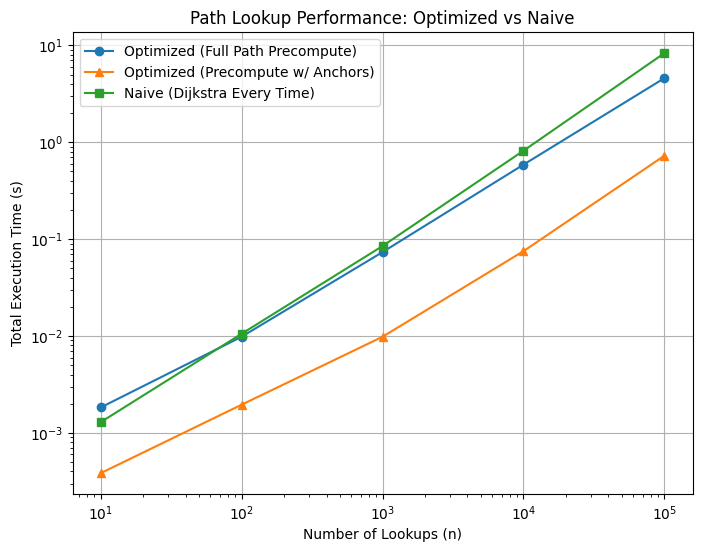

In [6]:
n_values = [10, 100, 1000, 10000, 100000]
optimized_times_alpha = []  # Full path optimized
optimized_times_beta = []   # Anchor-node optimized
optimized_times_gamma = []   # Anchor-node, intra-cell pre-computed path optimized
naive_times = []

original_hex_cache = testnet.hex_path_cache
original_path_cache = testnet.path_cache

for n in n_values:
    # Reset counters
    hex_cache_hits = 0
    path_cache_hits = 0
    new_paths_added = 0

    # Reset cache
    testnet.hex_path_cache = original_hex_cache
    testnet.path_cache = original_path_cache

    # Optimized Alpha (Full path optimized)
    opt_time_alpha = timeit.timeit(
        "optimized_path_lookup_alpha()",
        globals=globals(),
        number=n
    )
    optimized_times_alpha.append(opt_time_alpha)

    # Optimized Beta (Anchor-based path optimization)
    opt_time_beta = timeit.timeit(
        "optimized_path_lookup_beta()",
        globals=globals(),
        number=n
    )
    optimized_times_beta.append(opt_time_beta)

    # Optimized Gamma (Anchor-based, intra-cell pre-computed path optimization)
    #opt_time_gamma = timeit.timeit(
    #    "optimized_path_lookup_gamma()",
    #    globals=globals(),
    #    number=n
    #)
    #optimized_times_gamma.append(opt_time_gamma)

    # Naive (Dijkstra Every Time)
    naive_time = timeit.timeit(
        "naive_path_lookup()",
        globals=globals(),
        number=n
    )
    naive_times.append(naive_time)

    print(f"n={n}:")
    print(f"  Optimized (Full Path)     = {opt_time_alpha:.4f}s")
    print(f"  Optimized (Anchor Nodes)  = {opt_time_beta:.4f}s")
    #print(f"  Optimized (Anchor Nodes, Intra-cell)  = {opt_time_gamma:.4f}s")
    print(f"  Naive (Dijkstra Every Time) = {naive_time:.4f}s")
    print(f"  Cache Stats -> Hex Cache Hits: {hex_cache_hits}, Path Cache Hits: {path_cache_hits}, New Paths Added: {new_paths_added}")

# Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(n_values, optimized_times_alpha, marker='o', label='Optimized (Full Path Precompute)')
plt.plot(n_values, optimized_times_beta, marker='^', label='Optimized (Precompute w/ Anchors)')
#plt.plot(n_values, optimized_times_gamma, marker='s', label='Optimized (Precompute w/ Anchors, Intra-cell)')
plt.plot(n_values, naive_times, marker='s', label='Naive (Dijkstra Every Time)')
plt.xlabel('Number of Lookups (n)')
plt.ylabel('Total Execution Time (s)')
plt.title('Path Lookup Performance: Optimized vs Naive')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [17]:
cache_match

array([], shape=(0, 13572),
      dtype=[('pair', 'O'), ('path', 'O'), ('distance', '<f8')])

In [12]:
np.random.choice(testnet.G_rx.nodes())

91